In [1]:
# 从sklearn 调入所需要的包
# from sklearn import datasets

import os
import json
import gc
# os.system('pip install numba')
from numba import jit
#tqdm
# os.system('pip install tqdm')
from tqdm import tqdm_notebook
from tqdm import tqdm

#Integrated model
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
# import xgboost as xgb

#base import 
import numpy as np
import pandas as pd

# about sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
#about time
import time
import datetime 
from datetime import datetime, timedelta

#Garbage collection
import gc
# scipy
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import scipy.spatial.distance as dist
#other
from collections import Counter 
from statistics import mode 
    #warning
import warnings
warnings.filterwarnings("ignore")
import json 
import math
from itertools import product
import ast
from sklearn.model_selection import train_test_split #数据分隔出训练集和验证集
import lightgbm as lgb
import numpy as np 
import pandas as pd
#导入精度和召回
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
pd.set_option('display.max_columns',None)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
path='./'
train = pd.read_csv(path+'input/train.csv')
test = pd.read_csv(path+'input/test.csv')
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [4]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

In [5]:
test.describe()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.00000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,1.358613,4.413734,0.417361,0.408132,0.393246,0.257191,0.163659,0.185905,0.000373,0.001595,0.009376,0.001039,0.012383,7.296862,0.660591,0.120399,0.154973,0.611057,0.439868,0.551740,8.292038,0.82994,-0.504895,0.725798,-0.158449,6.564297,0.910144,0.832311,1.327911,0.992134,62.284293,2.346606,0.379957,0.813637,0.276431,3.068325,0.449632,0.450453,0.450054,2.371390,1.885328,7.687805,3.009537,9.225854,2.338538,8.443167,5.438478,1.440265,2.875013,7.540367,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,4.296830e+05,1.986503,0.663002,2.700149,0.493453,1.355068,0.488471,0.437086,0.369966,0.389030,0.019309,0.039905,0.096375,0.032223,0.127251,3.541948,0.473509,0.325428,0.361879,0.287699,0.404678,0.794023,2.508331,0.37570,0.788753,2.154886,0.844566,5.500485,0.347283,0.373590,0.978741,0.091530,33.003714,0.831666,0.058385,0.224779,0.356835,0.729005,0.287213,0.287373,0.287254,1.116953,1.136763,1.333521,1.415155,1.460560,1.248601,2.906361,2.330081,1.200620,1.694072,2.745882,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000e+00,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,0.141421,0.275778,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.720218e+05,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.524404,7.000000,1.00000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.671234,0.333916,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.443070e+05,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.721110,7.000000,1.00000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.7660

In [6]:
train.corr()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,1.000000,-0.000188,0.000826,0.001646,-0.001307,0.000168,0.000022,-0.000093,0.002473,-0.000479,-0.002208,-0.001261,-0.001210,-0.000177,-0.001718,-0.001129,-0.001935,-0.000500,0.001344,0.000816,-0.000999,-0.003829,-0.000976,-0.001052,-0.000403,0.000354,0.002310,-0.000850,-0.001010,-0.002956,0.000748,0.000494,-0.000928,0.002047,0.002641,0.001007,0.001944,-0.000737,0.000709,-0.000331,0.000719,-0.000451,3.638318e-03,-0.000592,0.000957,0.000788,0.000836,0.000518,9.805336e-04,-0.001249,-0.001093,-0.000157,0.001609,-0.001227,-0.001412,-0.001267,-0.001387,0.000194,-0.001267
target,-0.000188,1.000000,0.018570,0.004534,0.008360,0.009360,0.029165,-0.034017,0.034218,0.013147,-0.008237,0.001815,0.002028,0.007810,0.002460,0.007443,-0.021506,-0.027778,0.037053,0.004555,0.022888,0.034800,0.030888,0.016256,-0.031534,0.032401,0.032900,0.020754,0.011537,-0.036395,-0.020342,0.005322,0.001038,0.006129,-0.001213,0.038790,0.053899,-0.004474,0.027667,0.001782,0.001360,0.001907,3.272046e-05,0.000771,0.000082,-0.000103,-0.001006,0.000719,1.060834e-03,0.000371,-0.001133,-0.000446,0.001362,-0.000490,0.000624,-0.000170,0.000552,-0.001744,-0.001072
ps_ind_01,0.000826,0.018570,1.000000,-0.001793,0.223408,0.066645,0.014823,-0.277458,0.005700,0.188583,0.162800,0.001847,-0.016727,-0.023406,-0.008776,-0.024971,0.122137,0.036896,0.101257,-0.112226,0.102212,0.183855,0.139125,-0.056121,-0.116987,0.043756,0.079042,0.213009,0.070192,-0.000639,0.138112,-0.102582,0.010794,0.008188,0.008252,0.161842,0.099752,0.034480,-0.056722,-0.000854,-0.000437,0.001214,-9.430788e-04,-0.001171,0.000147,-0.000658,0.002993,-0.000085,-1.344982e-03,-0.001263,0.001521,0.000199,-0.000891,-0.000397,-0.000012,-0.000868,-0.001504,-0.000162,-0.001464
ps_ind_02_cat,0.001646,0.004534,-0.001793,1.000000,-0.061189,0.147110,-0.014860,-0.125653,0.016398,0.030945,0.110076,-0.000744,0.000772,-0.004616,-0.001187,-0.003649,-0.003854,0.012682,-0.018727,-0.000374,0.061118,0.084260,0.070790,0.002149,0.045233,-0.002532,-0.072190,-0.008407,-0.017301,-0.011781,0.001526,0.009435,0.011401,0.014955,0.019949,-0.110247,-0.080408,-0.012272,-0.008391,0.000683,0.000932,-0.000322,-2.111049e-03,-0.001548,0.000085,-0.000172,-0.002712,0.000356,-2.542520e-05,0.000038,-0.000884,-0.000893,-0.000519,-0.000109,0.000920,0.000547,0.000824,0.000367,-0.002070
ps_ind_03,-0.001307,0.008360,0.223408,-0.061189,1.000000,-0.095856,0.053250,-0.045158,-0.060368,0.014037,0.111306,0.006865,-0.003986,0.001698,0.003929,0.001990,0.170449,-0.018251,0.027691,0.001316,0.003209,0.048338,0.002348,-0.028520,-0.044907,0.095658,0.072990,0.143597,0.008021,0.056337,0.003607,-0.013205,-0.008561,-0.025966,-0.059358,0.088992,0.048308,0.000539,-0.048096,0.000703,-0.000335,0.000177,7.029223e-04,-0.001245,0.002361,0.001533,0.001267,-0.001544,2.302873e-04,-0.002716,-0.002352,0.000133,0.000205,0.000134,-0.000744,0.000158,-0.000218,-0.000882,-0.003709
ps_ind_04_cat,0.000168,0.009360,0.066645,0.147110,-0.095856,1.000000,0.013053,-0.297737,0.304949,0.044978,-0.011442,0.000789,0.001018,-0.001217,-0.000893,-0.000691,0.077071,0.017497,0.007830,-0.025797,0.023846,0.079471,0.065702,0.029379,0.003162,0.022744,-0.045361,0.063399,0.025324,0.064655,-0.008148,-0.041983,0.023010,-0.000615,0.073486,-0.095160,-0.032233,-0.005596,0.040480,-0.002753,-0.000544,0.000

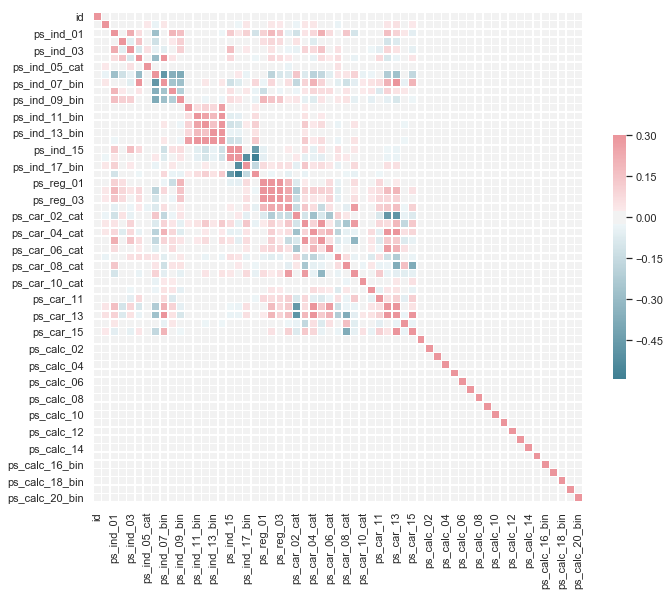

In [7]:
#查看特征直接的相关性
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
# 计算训练集的相关性
corr = train.corr()
# 设置 matplotlib f的尺寸
f, ax = plt.subplots(figsize=(11, 9))
# 生成自定义的散色图
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# 为热力图设置长宽比
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [8]:
#所有特征
features = [i for i in train.columns if i not in['target']]
# 数值特征
numeric_features = [i for i in features if i[-3:] not in ['bin', 'cat']]
# 类别 特征
categorical_features = [i for i in features if i[-3:]=='cat']
# 二值 Features
binary_features = [i for i in features if i[-3:]=='bin']


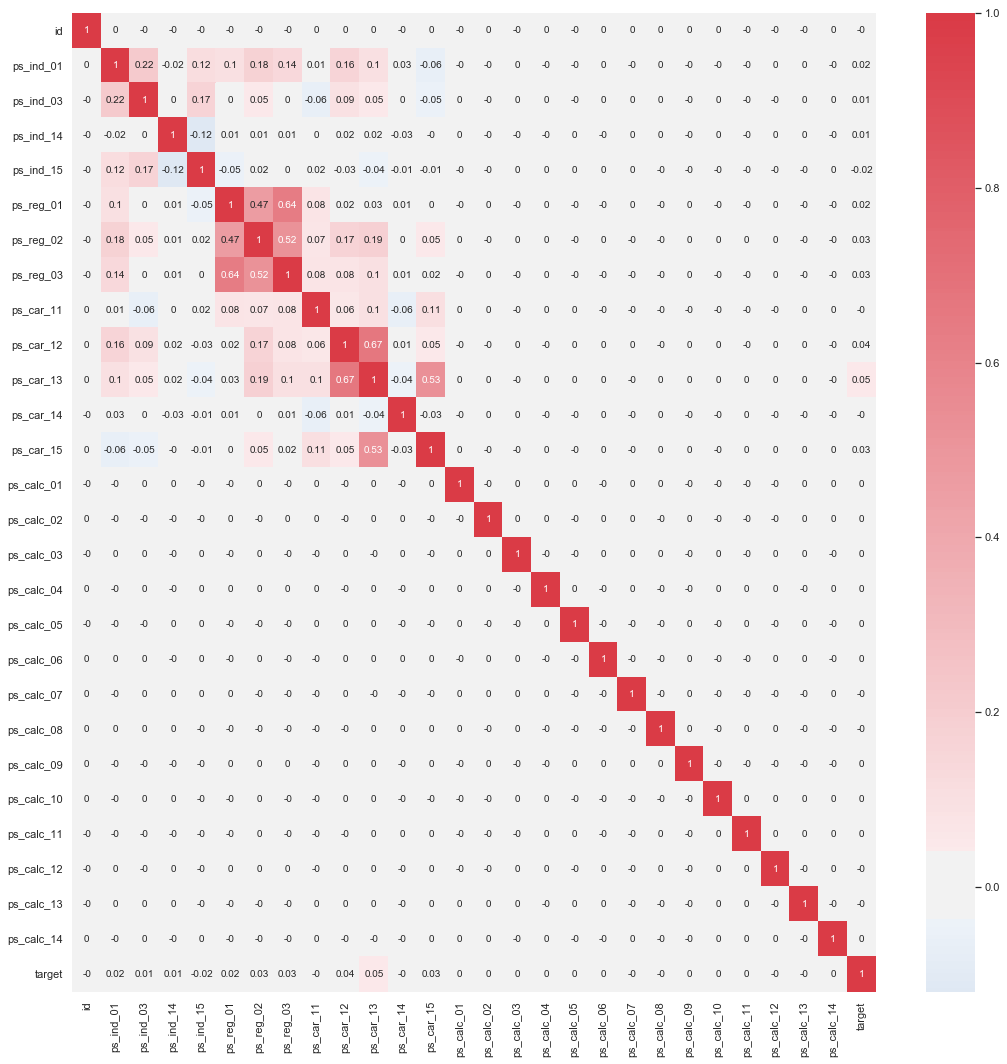

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
cor_matrix = train[numeric_features+['target']].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

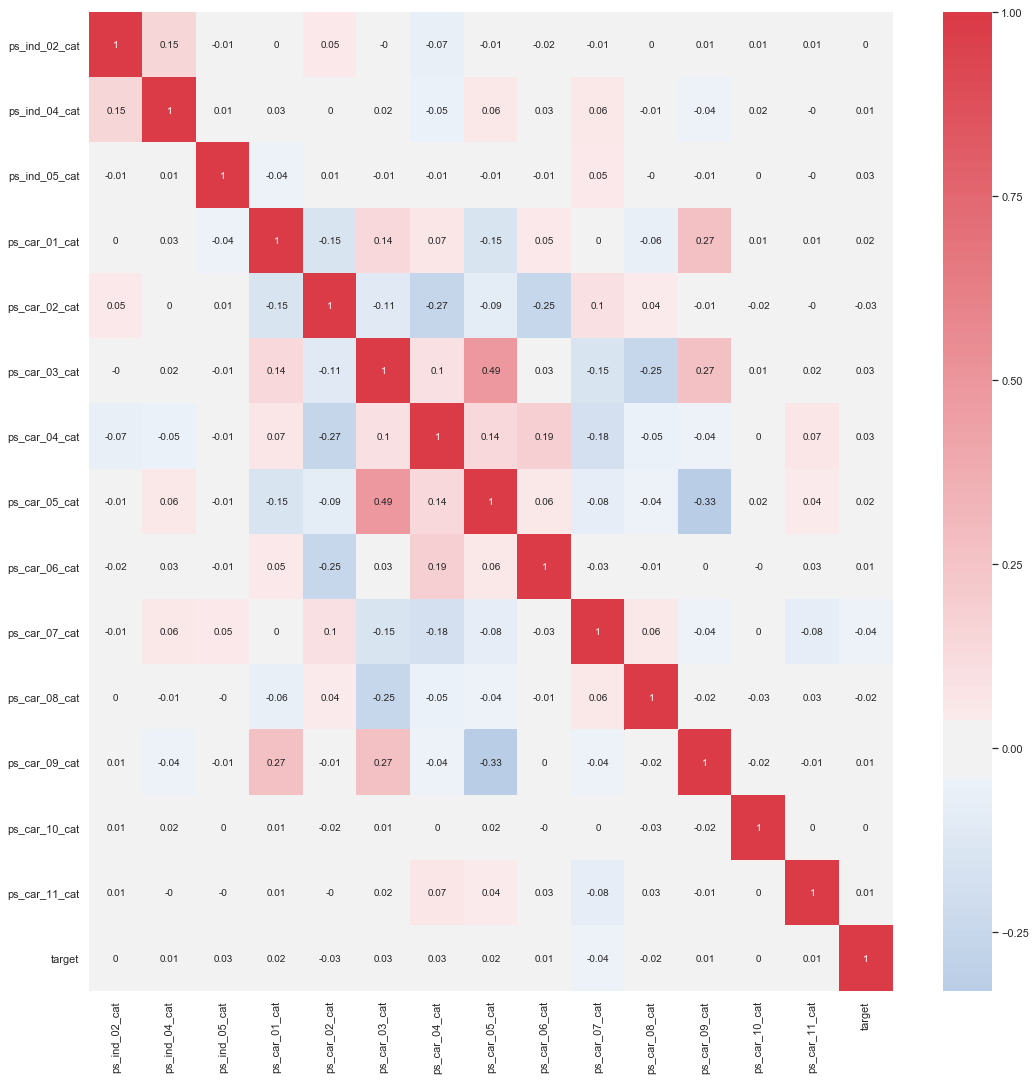

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
cor_matrix = train[categorical_features+['target']].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

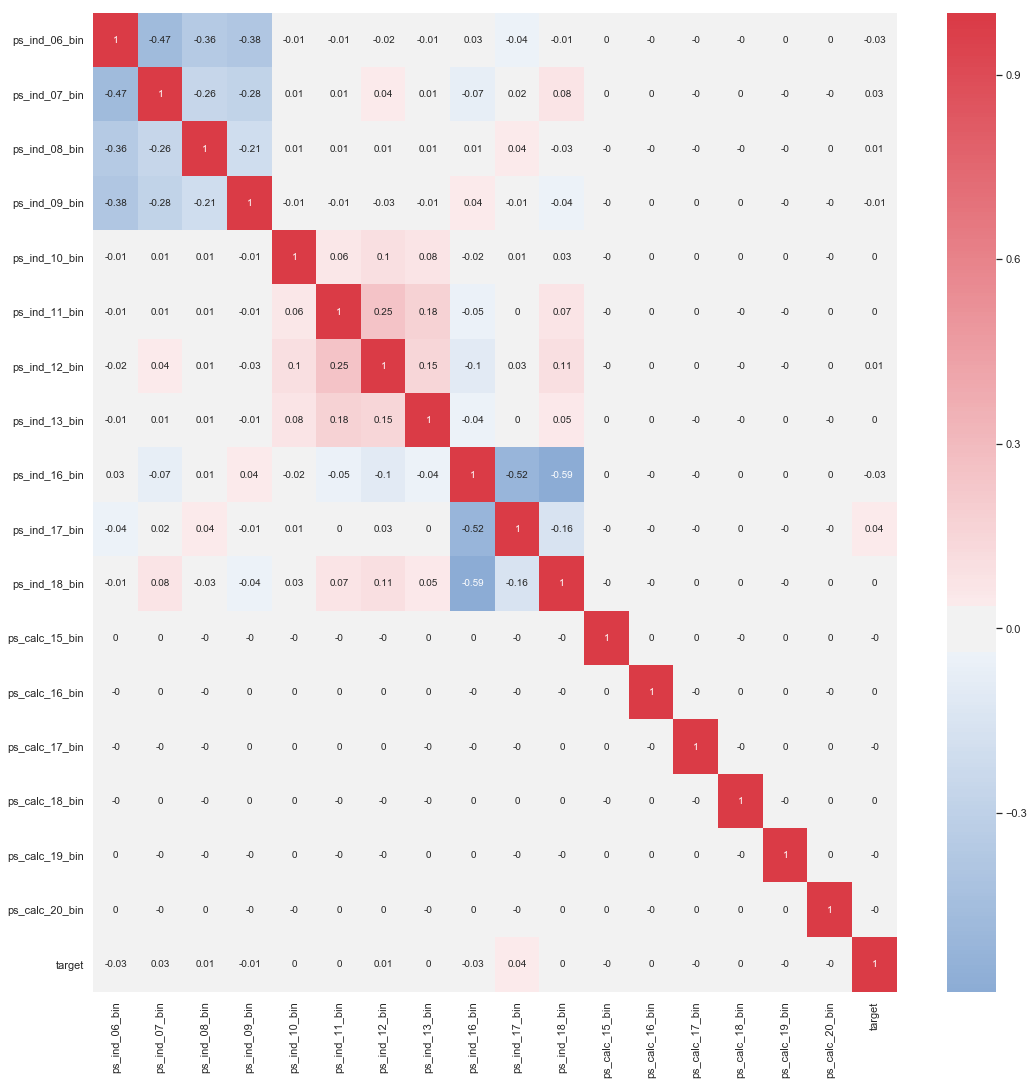

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
cor_matrix = train[binary_features+['target']].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [12]:
train.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


#### 尝试1：直接baseline 的得分：

#### 尝试2： 添加 列等于-1的计数：得分：

In [5]:
test['target']=-1
data = train.append(test).reset_index(drop=True)
#统计数据中==-1的个数
# data['missing'] = (data==-1).sum(axis=1).astype(float)
# # data = pd.concat([train,test]).rese_index(drop=True)
# print(data.head())

In [14]:
train.target.value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [15]:
test['target']=-1
print(len(test.columns))

59


In [16]:
# cat_col = categorical_features
# for i in tqdm_notebook(cat_col):
# #     lbl = LabelEncoder()
#     data['count_' + i] = data.groupby([i])[i].transform('count')
# #     data[i] = lbl.fit_transform(data[i].astype(str))

In [17]:
# ind_features = [c for c in features if 'ind' in c]
# count=0
# for c in ind_features:
#     if count==0:
#         data['new_ind'] = data[c].astype(str)+'_'
#         count+=1
#     else:
#         data['new_ind'] += data[c].astype(str)+'_'


# cat_count_features = []
# for c in categorical_features+['new_ind']:
#     d = data[c].value_counts().to_dict()
#     data['%s_count'%c] = data[c].apply(lambda x:d.get(x,0))
#     cat_count_features.append('%s_count'%c)
# del data['new_ind']

In [18]:
# for column in categorical_features:
#     temp = pd.get_dummies(pd.Series(data[column]))
#     data = pd.concat([data, temp], axis = 1)
#     data = data.drop([column], axis=1)

In [19]:
data.head()

,id,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_11_cat,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
0,7,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1,10,1,-1,0,1,4,1,0,0,1,2,12,0.400000,0.883679,0.370810,3.605551,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,0.0
1,9,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0,11,1,-1,0,-1,11,1,1,2,1,3,19,0.316228,0.618817,0.388716,2.449490,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,0.0
2,13,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0,7,1,-1,0,-1,14,1,1,2,1,1,60,0.316228,0.641586,0.347275,3.316625,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,0.0
3,16,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0,7,1,0,0,1,11,1,1,3,1,1,104,0.374166,0.542949,0.294958,2.000000,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,0.0
4,17,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0,11,1,-1,0,-1,14,1,1,2,1,3,82,0.316070,0.565832,0.365103,2.000000,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,0.0


In [20]:
data.head()

,id,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_11_cat,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
0,7,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1,10,1,-1,0,1,4,1,0,0,1,2,12,0.400000,0.883679,0.370810,3.605551,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,0.0
1,9,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0,11,1,-1,0,-1,11,1,1,2,1,3,19,0.316228,0.618817,0.388716,2.449490,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,0.0
2,13,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0,7,1,-1,0,-1,14,1,1,2,1,1,60,0.316228,0.641586,0.347275,3.316625,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,0.0
3,16,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0,7,1,0,0,1,11,1,1,3,1,1,104,0.374166,0.542949,0.294958,2.000000,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,0.0
4,17,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0,11,1,-1,0,-1,14,1,1,2,1,3,82,0.316070,0.565832,0.365103,2.000000,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,0.0


In [6]:
feats = [i for i in data.columns if i not in ['id','target']]
feats

['ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_13',
 'ps_calc_14',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11',
 'ps_car_11_cat',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03']

In [7]:
features = feats

#### 贝叶斯调参：
！pip install bayesian-optimization

In [23]:
from bayes_opt import BayesianOptimization

In [62]:
train_df = data[data['target']!=-1]
train_y = data[data['target']!=-1]
test_df = data[data['target']==-1]

In [50]:
bayesian_tr_idx, bayesian_val_idx = train_test_split(train_df, test_size = 0.3, random_state = 42, stratify =train_df['target'] )
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [54]:
target = 'target'

In [55]:
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              #'learning_rate' : learning_rate,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(train_df))
    trn_data= lgb.Dataset(train_df.iloc[bayesian_tr_idx][features].values, label=train_df.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(train_df.iloc[bayesian_val_idx][features].values, label=train_df.iloc[bayesian_val_idx][target].values)

    clf = lgb.train(param, trn_data,  num_boost_round=50, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 50)
    
    oof[bayesian_val_idx]  = clf.predict(train_df.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(train_df.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])

    return score

In [56]:
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    #'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,50),
}
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [57]:
init_points = 10
n_iter = 15
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6364   |  0.3996   |  0.8606   |  36.33    |  0.005991 |  48.08    |  104.2    |  1.058    |  1.866    |
|  2        |  0.6375   |  0.5809   |  0.6665   |  0.04981  |  0.009699 |  169.8    |  130.6    |  1.182    |  1.183    |
|  3        |  0.6406   |  0.3434   |  0.5198   |  21.03    |  0.002919 |  130.1    |  96.42    |  1.292    |  1.366    |
|  4        |  0.6413   |  0.4649   |  0.7281   |  9.183    |  0.005147 |  126.6    |  52.79    |  1.608    |  1.171    |
|  5        |  0.6408   |  0.152    |  0.8591   |  48.25    |  0.008086 |  74.83    |  76.81    |  1.684    |  1.44     |
|  6        |  

In [58]:
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [59]:
LGB_BO.max['params']

{'bagging_fraction': 0.46485598737362877,
 'feature_fraction': 0.728140769114411,
 'max_depth': 9.183362890076346,
 'min_child_weight': 0.0051472020397519795,
 'min_data_in_leaf': 126.63462239516764,
 'num_leaves': 52.78524356567893,
 'reg_alpha': 1.6075448519014384,
 'reg_lambda': 1.1705241236872914}

In [60]:
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        #'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }


fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726933	valid_1's auc: 0.629539
Early stopping, best iteration is:
[47]	training's auc: 0.689408	valid_1's auc: 0.630457


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.728484	valid_1's auc: 0.640452
Early stopping, best iteration is:
[59]	training's auc: 0.69885	valid_1's auc: 0.641999


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726257	valid_1's auc: 0.638314
Early stopping, best iteration is:
[60]	training's auc: 0.69895	valid_1's auc: 0.639839

fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726899	valid_1's auc: 0.63909
Early stopping, best iteration is:
[60]	training's auc: 0.698249	valid_1's auc: 0.640496


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



fold 5
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.726877	valid_1's auc: 0.638756
Early stopping, best iteration is:
[57]	training's auc: 0.69668	valid_1's auc: 0.640685


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



CV roc score        : 0.6387, std: 0.0042. 
CV accuracy score   : 0.9636, std: 0.0000. 
CV recall score     : 0.0000, std: 0.0001. 
CV precision score  : 0.1000, std: 0.2000. 
CV f1 score         : 0.0001, std: 0.0002.


NameError: name 'plot_confusion_matrix' is not defined

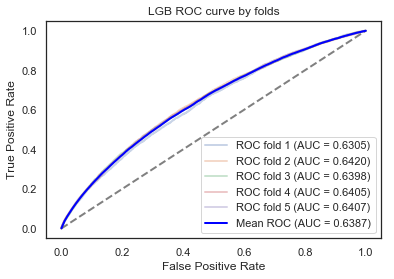

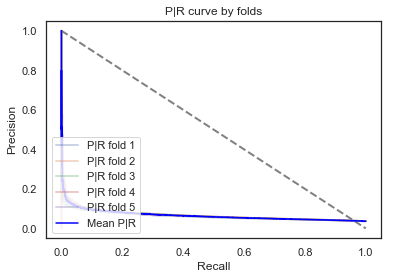

<Figure size 432x288 with 0 Axes>

In [66]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.target.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train_df.iloc[train_idx][features].values,
                                   label=train_df.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train_df.iloc[valid_idx][features].values,
                                   label=train_df.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'LGB Confusion matrix [averaged/folds]')
plt.show()

In [67]:
sample_submission = pd.read_csv(path+'input/sample_submission.csv')
sample_submission.head()

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


#### 贝叶斯调参得分原始特征：0.28375  0.27854

In [70]:
sample_submission['target'] = predictions
sample_submission.to_csv('submission_porto.csv',index=False)

In [28]:
model = lgb.LGBMClassifier(
        boosting_type="gbdt", num_leaves=15, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=1500, objective='binary',metric= 'F1',
    subsample=0.95, colsample_bytree=0.95, subsample_freq=1,
    learning_rate=0.05, random_state=2017
    )

In [29]:
#5折交叉验证
from sklearn.model_selection import KFold
n_splits=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_x = data[data['target']!=-1][feats]
train_y = data[data['target']!=-1]['target']
res=data[data['target']==-1][['target']]

test_x= data[data['target']==-1][feats]
res['target'] = 0
for train_idx, val_idx in kfold.split(train_x):
    model.random_state = model.random_state + 1
    train_x1 = train_x.loc[train_idx]
    train_y1 = train_y.loc[train_idx]
    test_x1 = train_x.loc[val_idx]
    test_y1 = train_y.loc[val_idx]
    #,(vali_x,vali_y)
    model.fit(train_x1, train_y1,eval_set=[(train_x1, train_y1),(test_x1, test_y1)],eval_metric='auc',early_stopping_rounds=100)#categorical_feature=categorical_features
    res['target'] += model.predict_proba(test_x)[:,1]

res['target'] = res['target']/5
target_mean = np.mean(res['target'])


[1]	training's auc: 0.600262	valid_1's auc: 0.599704
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.609987	valid_1's auc: 0.609663
[3]	training's auc: 0.614092	valid_1's auc: 0.613019
[4]	training's auc: 0.617818	valid_1's auc: 0.616907
[5]	training's auc: 0.61739	valid_1's auc: 0.616479
[6]	training's auc: 0.619622	valid_1's auc: 0.618545
[7]	training's auc: 0.620133	valid_1's auc: 0.618537
[8]	training's auc: 0.622498	valid_1's auc: 0.620238
[9]	training's auc: 0.623475	valid_1's auc: 0.621206
[10]	training's auc: 0.624146	valid_1's auc: 0.621479
[11]	training's auc: 0.625223	valid_1's auc: 0.622564
[12]	training's auc: 0.627022	valid_1's auc: 0.624177
[13]	training's auc: 0.627703	valid_1's auc: 0.624475
[14]	training's auc: 0.629145	valid_1's auc: 0.625564
[15]	training's auc: 0.630294	valid_1's auc: 0.626302
[16]	training's auc: 0.630828	valid_1's auc: 0.626847
[17]	training's auc: 0.631208	valid_1's auc: 0.626959
[18]	training's auc: 0.631984

[300]	training's auc: 0.692612	valid_1's auc: 0.640717
[301]	training's auc: 0.692702	valid_1's auc: 0.640669
[302]	training's auc: 0.692918	valid_1's auc: 0.640588
[303]	training's auc: 0.69296	valid_1's auc: 0.64057
[304]	training's auc: 0.693052	valid_1's auc: 0.640522
[305]	training's auc: 0.693236	valid_1's auc: 0.64053
[306]	training's auc: 0.693384	valid_1's auc: 0.640558
[307]	training's auc: 0.693567	valid_1's auc: 0.64057
Early stopping, best iteration is:
[207]	training's auc: 0.676009	valid_1's auc: 0.641354
[1]	training's auc: 0.603849	valid_1's auc: 0.595176
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.61177	valid_1's auc: 0.605107
[3]	training's auc: 0.618683	valid_1's auc: 0.612601
[4]	training's auc: 0.619208	valid_1's auc: 0.613519
[5]	training's auc: 0.620953	valid_1's auc: 0.615649
[6]	training's auc: 0.621555	valid_1's auc: 0.615892
[7]	training's auc: 0.62199	valid_1's auc: 0.616432
[8]	training's auc: 0.623461	valid_1's auc

[142]	training's auc: 0.665304	valid_1's auc: 0.635253
[143]	training's auc: 0.665555	valid_1's auc: 0.635208
[144]	training's auc: 0.665732	valid_1's auc: 0.635193
[145]	training's auc: 0.665828	valid_1's auc: 0.635241
[146]	training's auc: 0.666035	valid_1's auc: 0.635302
[147]	training's auc: 0.666227	valid_1's auc: 0.635287
[148]	training's auc: 0.666375	valid_1's auc: 0.635268
[149]	training's auc: 0.666643	valid_1's auc: 0.63526
[150]	training's auc: 0.666762	valid_1's auc: 0.635205
[151]	training's auc: 0.666841	valid_1's auc: 0.635165
[152]	training's auc: 0.667194	valid_1's auc: 0.635241
[153]	training's auc: 0.667437	valid_1's auc: 0.635236
[154]	training's auc: 0.667622	valid_1's auc: 0.635205
[155]	training's auc: 0.667782	valid_1's auc: 0.635146
[156]	training's auc: 0.668018	valid_1's auc: 0.635307
[157]	training's auc: 0.668187	valid_1's auc: 0.635294
[158]	training's auc: 0.668349	valid_1's auc: 0.635314
[159]	training's auc: 0.668532	valid_1's auc: 0.635268
[160]	train

[148]	training's auc: 0.664828	valid_1's auc: 0.646034
[149]	training's auc: 0.664996	valid_1's auc: 0.64604
[150]	training's auc: 0.665121	valid_1's auc: 0.646073
[151]	training's auc: 0.665262	valid_1's auc: 0.64607
[152]	training's auc: 0.665518	valid_1's auc: 0.646135
[153]	training's auc: 0.665742	valid_1's auc: 0.646182
[154]	training's auc: 0.665916	valid_1's auc: 0.646195
[155]	training's auc: 0.666134	valid_1's auc: 0.646332
[156]	training's auc: 0.666407	valid_1's auc: 0.64629
[157]	training's auc: 0.666541	valid_1's auc: 0.646326
[158]	training's auc: 0.666725	valid_1's auc: 0.646221
[159]	training's auc: 0.666854	valid_1's auc: 0.646228
[160]	training's auc: 0.667169	valid_1's auc: 0.646183
[161]	training's auc: 0.667354	valid_1's auc: 0.64619
[162]	training's auc: 0.667539	valid_1's auc: 0.646181
[163]	training's auc: 0.667657	valid_1's auc: 0.646112
[164]	training's auc: 0.66782	valid_1's auc: 0.64609
[165]	training's auc: 0.667994	valid_1's auc: 0.646054
[166]	training's

[190]	training's auc: 0.674331	valid_1's auc: 0.635737
[191]	training's auc: 0.674538	valid_1's auc: 0.635731
[192]	training's auc: 0.674843	valid_1's auc: 0.635689
[193]	training's auc: 0.675074	valid_1's auc: 0.635741
[194]	training's auc: 0.675312	valid_1's auc: 0.635673
[195]	training's auc: 0.67548	valid_1's auc: 0.635757
[196]	training's auc: 0.675692	valid_1's auc: 0.63578
[197]	training's auc: 0.675852	valid_1's auc: 0.635827
[198]	training's auc: 0.675992	valid_1's auc: 0.635809
[199]	training's auc: 0.676276	valid_1's auc: 0.635794
[200]	training's auc: 0.67643	valid_1's auc: 0.63584
[201]	training's auc: 0.676659	valid_1's auc: 0.635857
[202]	training's auc: 0.676916	valid_1's auc: 0.63583
[203]	training's auc: 0.677116	valid_1's auc: 0.635866
[204]	training's auc: 0.67721	valid_1's auc: 0.635879
[205]	training's auc: 0.67737	valid_1's auc: 0.635968
[206]	training's auc: 0.677625	valid_1's auc: 0.635936
[207]	training's auc: 0.677776	valid_1's auc: 0.635961
[208]	training's 

[488]	training's auc: 0.717649	valid_1's auc: 0.637116
[489]	training's auc: 0.717863	valid_1's auc: 0.637071
[490]	training's auc: 0.717979	valid_1's auc: 0.637032
[491]	training's auc: 0.718107	valid_1's auc: 0.637098
[492]	training's auc: 0.718177	valid_1's auc: 0.637048
[493]	training's auc: 0.718265	valid_1's auc: 0.637031
[494]	training's auc: 0.718384	valid_1's auc: 0.637077
[495]	training's auc: 0.718568	valid_1's auc: 0.637013
[496]	training's auc: 0.71861	valid_1's auc: 0.637012
[497]	training's auc: 0.718718	valid_1's auc: 0.637055
[498]	training's auc: 0.718799	valid_1's auc: 0.637043
[499]	training's auc: 0.718833	valid_1's auc: 0.6371
[500]	training's auc: 0.71888	valid_1's auc: 0.637117
[501]	training's auc: 0.718948	valid_1's auc: 0.637143
[502]	training's auc: 0.719088	valid_1's auc: 0.637146
[503]	training's auc: 0.719155	valid_1's auc: 0.637116
[504]	training's auc: 0.719176	valid_1's auc: 0.637112
[505]	training's auc: 0.719278	valid_1's auc: 0.637148
[506]	training

[179]	training's auc: 0.672459	valid_1's auc: 0.63575
[180]	training's auc: 0.672581	valid_1's auc: 0.635701
[181]	training's auc: 0.672884	valid_1's auc: 0.63567
[182]	training's auc: 0.672986	valid_1's auc: 0.635652
[183]	training's auc: 0.673127	valid_1's auc: 0.635679
[184]	training's auc: 0.673309	valid_1's auc: 0.635687
[185]	training's auc: 0.673635	valid_1's auc: 0.635691
[186]	training's auc: 0.673742	valid_1's auc: 0.635657
[187]	training's auc: 0.673925	valid_1's auc: 0.635751
[188]	training's auc: 0.674249	valid_1's auc: 0.635773
[189]	training's auc: 0.674395	valid_1's auc: 0.635838
[190]	training's auc: 0.674589	valid_1's auc: 0.635794
[191]	training's auc: 0.674683	valid_1's auc: 0.635788
[192]	training's auc: 0.67505	valid_1's auc: 0.635768
[193]	training's auc: 0.67538	valid_1's auc: 0.63576
[194]	training's auc: 0.675539	valid_1's auc: 0.635774
[195]	training's auc: 0.675654	valid_1's auc: 0.635733
[196]	training's auc: 0.675825	valid_1's auc: 0.635741
[197]	training'

In [30]:
pd.DataFrame({'id':data[data['target']==-1]['id'],'target':res['target']}).to_csv(path+'output/lgb_proba{}.csv'.format(target_mean),index=False)

In [8]:
print(target_mean)

NameError: name 'target_mean' is not defined

In [36]:
train_label.value_counts()

0.0    573518
1.0     21694
Name: target, dtype: int64

In [45]:
train_label.target.isnull().sum()

892816

In [9]:
train_label = data[data['target']!=-1][['target']]
train_label['target']=train_label['target'].astype('int')

In [21]:
train = data[data['target']!=-1].fillna(0)
train_label = data[data['target']!=-1]['target']
test = data[data['target']==-1].fillna(0)
train_list = train[feats]
test_list = test[feats]
test_id =data[data['target']==-1]['id']

In [22]:
type(train_list)

pandas.core.frame.DataFrame

In [25]:
import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)
cv_only = True
save_cv = True
full_train = False
from scipy import sparse as ssp

def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

cv_only = True
save_cv = True
full_train = False

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

X = ssp.csr_matrix(train_list)
X_test = ssp.csr_matrix(test_list)

# X = ssp.hstack(train_list).tocsr()
# X_test = ssp.hstack(test_list).tocsr()
# X = train_list
# X_test = test_list
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in range(16):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only:
        kf = kfold.split(X, train_label)

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100)
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)

            score = Gini(label_validate, cv_train[validate])
            print (score)
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print (Gini(train_label, cv_train))
        print ("current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

print(x_score)
pd.DataFrame({'id': test_id, 'target': final_cv_pred / 16.}).to_csv('./model/lgbm3_pred_avg.csv', index=False)
# pd.DataFrame({'id': train_id, 'target': final_cv_train / 16.}).to_csv('./model/lgbm3_cv_avg.csv', index=False)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151634	valid_0's gini: 0.286522
[200]	valid_0's binary_logloss: 0.151663	valid_0's gini: 0.284746
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.151608	valid_0's gini: 0.287197
0.2871968044984855
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.15226	valid_0's gini: 0.270299
[200]	valid_0's binary_logloss: 0.152268	valid_0's gini: 0.271789
[300]	valid_0's binary_logloss: 0.152358	valid_0's gini: 0.270892
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.152241	valid_0's gini: 0.27318
0.27318020251916236
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152069	valid_0's gini: 0.280359
[200]	valid_0's binary_logloss: 0.152039	valid_0's gini: 0.28127
[300]	valid_0's binary_logloss: 0.152077	valid_0's gini: 0.279999
Early stopping, best iteration is:
[227]	vali

0.28307493583481746
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151697	valid_0's gini: 0.286166
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.151689	valid_0's gini: 0.286316
0.28631567966255284
cv score:
0.2818794738098501
current score: 0.284162733694586 5
[0.2893418850546984, 0.2710301470850382, 0.2807468752864172, 0.28307493583481746, 0.28631567966255284]
[97, 235, 97, 179, 86] 138.8
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151611	valid_0's gini: 0.287888
[200]	valid_0's binary_logloss: 0.151569	valid_0's gini: 0.288801
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.151566	valid_0's gini: 0.289137
0.2891371595861429
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152242	valid_0's gini: 0.26928
[200]	valid_0's binary_logloss: 0.152221	valid_0's gini: 0.271273
Early stopping, best itera

[200]	valid_0's binary_logloss: 0.152101	valid_0's gini: 0.279633
[300]	valid_0's binary_logloss: 0.152164	valid_0's gini: 0.278069
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.152077	valid_0's gini: 0.280582
0.2805820332292268
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151871	valid_0's gini: 0.280531
[200]	valid_0's binary_logloss: 0.151874	valid_0's gini: 0.280028
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.151815	valid_0's gini: 0.281862
0.2818618306150736
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151749	valid_0's gini: 0.284237
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.151717	valid_0's gini: 0.285277
0.28527727312689655
cv score:
0.28121368704591365
current score: 0.2844193403326682 10
[0.289985336085231, 0.26878960754273146, 0.2805820332292268, 0.2818618306150736, 0.28527727312689655]
[165, 155, 213,

[212]	valid_0's binary_logloss: 0.151532	valid_0's gini: 0.290199
0.29019937237133153
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152256	valid_0's gini: 0.269684
[200]	valid_0's binary_logloss: 0.152287	valid_0's gini: 0.270168
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.152225	valid_0's gini: 0.271252
0.2712524413469931
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.152197	valid_0's gini: 0.278146
[200]	valid_0's binary_logloss: 0.152154	valid_0's gini: 0.279347
[300]	valid_0's binary_logloss: 0.152172	valid_0's gini: 0.279633
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.152127	valid_0's gini: 0.28012
0.28011998039239067
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.151797	valid_0's gini: 0.283019
[200]	valid_0's binary_logloss: 0.15186	valid_0's gini: 0.280483
Early stopping, best ite

NameError: name 'train_id' is not defined

In [ ]:
#统计数据中==-1的个数
data['missing'] = (data==-1).sum(axis=1).astype(float)
def encode_onehot(df,column_name):
    feature_df=pd.get_dummies(df[column_name], prefix=column_name)
    all = pd.concat([df.drop([column_name], axis=1),feature_df], axis=1)
    return all
for i in categorical_features:
    data = encode_onehot(data,i)



ind_features = [c for c in features if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        data['new_ind'] = data[c].astype(str)+'_'
        count+=1
    else:
        data['new_ind'] += data[c].astype(str)+'_'


cat_count_features = []
for c in categorical_features+['new_ind']:
    d = data[c].value_counts().to_dict()
    data['%s_count'%c] = data[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)
del data['new_ind']

# cat_col = categorical_features
# for i in tqdm_notebook(cat_col):
# #     lbl = LabelEncoder()
#     data['count_' + i] = data.groupby([i])[i].transform('count')
# #     data[i] = lbl.fit_transform(data[i].astype(str))